In [1]:
# Run all the code 
# ! bash example.sh

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP
from layers import GraphConv
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.sparse.csgraph import connected_components

from tqdm import trange
import numpy as np
import copy 
import time
import pickle
import os

DATASET = 'cora'
SAVE_DIR = './exp_results/figures/%s/'%DATASET

layers = [i for i in range(2,9)]
repeats = [i for i in range(10)] 

In [6]:
def get_result(algo, layer=10):
    train_acc_record = []
    train_loss_record = []
    valid_acc_record = []
    valid_loss_record = []
    
    test_acc_record = []
    for repeat in repeats:
        
        save_path = os.path.join('exp_results/%s/'%DATASET, 
                                 'results_%s_L%d_repteat%d.pkl'%(DATASET, layer, repeat))
        with open(save_path, 'rb') as f:
            results_list = pickle.load(f)
            
        for result in results_list:
            if result.note == '%s (L=%d)'%(algo, layer):
                break

        train_acc_record.append(result.train_acc_record)
        train_loss_record.append(result.train_loss_record)
        valid_acc_record.append(result.acc_record)
        valid_loss_record.append(result.loss_record)
        
        test_acc_record.append(result.test_acc)
    return train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record

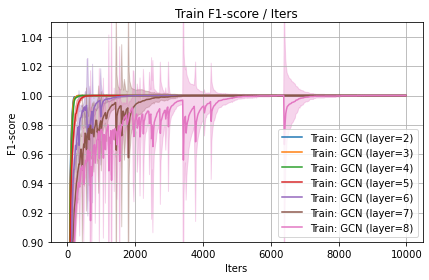

In [8]:
# plot_train, plot_valid, plot_gap=False, False, True
plot_train, plot_valid, plot_gap=True, False, False

fig, axs = plt.subplots()

for ALGORITHM in ['GCN']:
    for layer in layers:
        train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record = get_result(ALGORITHM, layer)
        color = next(axs._get_lines.prop_cycler)['color']
        if plot_train:
            data_mat = np.array(train_acc_record)
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/500)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips
            
            axs.plot(x_vals, y_vals, label='Train: %s (layer=%d)'%(ALGORITHM, layer), color=color)
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color)
        if plot_valid:
            data_mat = np.array(valid_acc_record)
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/500)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips

            axs.plot(x_vals, y_vals, label='Valid: %s (layer=%d)'%(ALGORITHM, layer), color=color, linestyle='--')
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color)
        if plot_gap:
            data_mat = np.abs(np.array(train_acc_record)-np.array(valid_acc_record))[:,:500]
            y_vals = np.mean(data_mat, axis=0)
            y_stds = np.std(data_mat, axis=0)
            skips = int(len(y_vals)/500)

            y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skips)]]
            y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skips)]]
            x_vals = np.arange(len(y_vals))*skips

            axs.plot(x_vals, y_vals, label='Valid: %s (layer=%d)'%(ALGORITHM, layer), color=color)
            axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
            
plt.title('Train F1-score / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('F1-score')
axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.ylim(0.9,1.05)
plt.legend()

plt.savefig('train_acc_%s_%s.pdf'%(DATASET, ALGORITHM))
# plt.close()